# 🎓 **Taller 4.3: Taller de Métodos de clustering basados en particiones Parte 2**


## OBJETIVOS DEL TALLER:
En esta práctica estudiaremos el funcionamiento y la utilización métodos de clustering basados en particiones, como el K-means y el K-medoids.

# 🔧 **CONFIGURACIÓN INICIAL**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.rcParams['figure.figsize'] = [8, 8]

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [2]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

✅ Dataset cargado desde URL GitHub


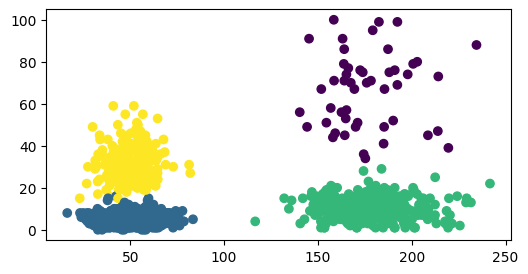

In [3]:
# Cargar dataset
D =cargar_dataset("dataset_cuatro_diferente_densidad.xlsx")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

# 🎯 **:Cree el algoritmo K-means que tiene un único parámetro: el número de clústeres (K).**

In [4]:
# PASO 1 elejir los centros iniciales de forma randomica
def random_sample_float(n, mi, ma):
    return (ma - mi) * np.random.random_sample(n) + mi

def paso1_elije_centros(K, Dx):
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])
  # 1.1 Completa el codigo aqui
  x1 = random_sample_float(K, np.min(Dx[:,0]), np.max(Dx[:,0]))
  x2 = random_sample_float(K, np.min(Dx[:,1]), np.max(Dx[:,1]))
  cDx[:,0] = x1
  cDx[:,1] = x2
  return cDx


Los centros iniciales elegidos aleatoriamente son:
[[158.57550069  77.08544153]
 [197.85415703  97.86473258]
 [ 64.92506307  96.46080998]
 [ 17.70569472  39.38574552]]


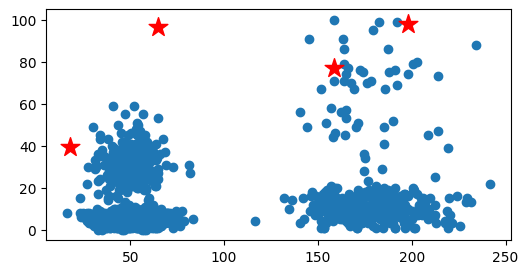

In [5]:
print('Los centros iniciales elegidos aleatoriamente son:')
K=4
cDx = paso1_elije_centros(K, Dx)
print(cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1])
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

2.   Paso de asignación de datos
En este paso, cada elemento de nuestro dataset se asigna al centroide más cercano basado en la distancia escogida: en nuestro caso, la Euclidiana. Por tanto, tendremos que implementar la siguiente operación:

$$
\DeclareMathOperator*{\argminA}{arg\,min}
\argminA_{c_i \in C} dist\left ( c_i, x \right )^2
$$

In [6]:
# Definimos la distancia euclidiana de una instancia x con respecto a un grupo de instancias C
def distancia_euclidiana_grupo(x, C):
  return np.linalg.norm(C - x, axis=1);

def paso2_asigna_puntos(Dx, cDx):
  Dyp = np.zeros(Dx.shape[0])
  # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
  for i in np.arange(Dx.shape[0]):
      # Tenemos que calcular la distancia de cada muestra del dataset Dx[i]
      # a cada centro existente en cDx. Podemos utilizar para ello la función
      # distancia_euclidiana_grupo.

      distancia_punto_a_centros = distancia_euclidiana_grupo(Dx[i],cDx ) # 1.2 Completa el codigo aqui

      # Una vez calculada la distancia, necesitamos averiguar el índice de
      # la distancia mínima. Para ello, podemos usar la función argmin de numpy.
      pred_y = np.argmin(distancia_punto_a_centros)
      Dyp[i] = pred_y
  return Dyp

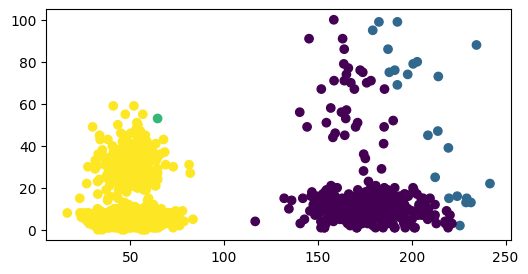

In [7]:
Dyp = paso2_asigna_puntos(Dx, cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

2.   Paso de actualización del centroide
En este paso se recalcula el centroide de cada cluster, teniendo en cuenta la nueva asignación calculada en el paso 1. Para ello, se calcula la media de todos los puntos asignados en el paso anterior.

$$
c_i = \frac{1}{\left | S_i \right |} \sum_{x_i \in S_i} x_i
$$


In [8]:
def paso3_actualiza_centros(Dx, cDx, Dyp, K):
  cDx_ant = cDx.copy()
  for k in range(K):
      # Seleccionamos los puntos asignados al cluster k
      puntos_cluster_k = Dx[Dyp == k]
      # Calculamos la media de las coordenadas x e y
      if len(puntos_cluster_k) > 0:  # Evitar división por cero si el cluster está vacío
          cDx[k,:] = np.mean(puntos_cluster_k, axis=0) # 1.3 Completa el codigo aqui
      else:
          # Si el cluster está vacío, mantenemos el centroide anterior
          cDx[k,:] = cDx_ant[k,:]
  return cDx

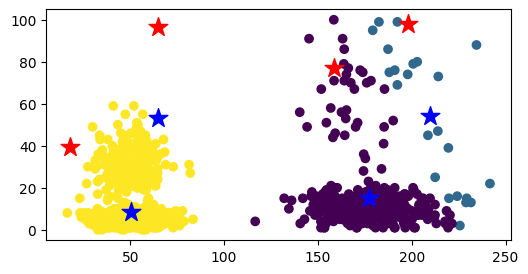

In [9]:
cDx_ant = cDx.copy()
cDx =paso3_actualiza_centros(Dx, cDx, Dyp, K)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='b')
ax.scatter(cDx_ant[:,0],cDx_ant[:,1], marker='*', s=200, c='r')

Y esto es todo. Este proceso se repite hasta cumplir un criterio de detención:

*   No hay cambios en los puntos asignados a cada cluster
*   La suma de las distancias alcanza un valor mínimo establecido
*   Se alcanza un número máximo de iteraciones

In [10]:
def MyKMeans(Dx, K):
  cDx = paso1_elije_centros(K, Dx) # 1.4 Completa el codigo aqui
  cDxIni = cDx.copy()
  # Flag de convergencia
  iterando = True
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos(Dx, cDx) # 1.5 Completa el codigo aqui
    # Calcular los nuevos centros
    #cDx = # 1.6 Completa el codigo aqui
    cDx =paso3_actualiza_centros(Dx, cDx, Dyp, K)
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp, cDxIni

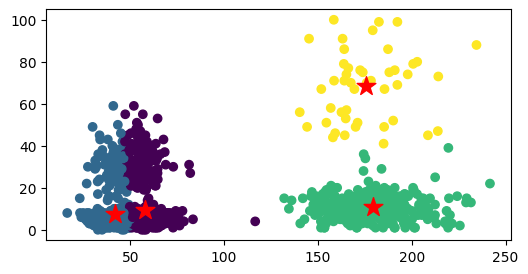

In [11]:
cDx, Dyp,cDxIni = MyKMeans(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# 🎯 **EJ 1: MODIFICA KMEANS PARA QUE SE CONVIERTA EN KMEANS++**

In [12]:
def distancia_euclidiana(a, b):
  return np.sqrt(np.sum((a - b) ** 2, axis=1))

def paso1_elije_centros_inteligente(K, Dx):
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])

  # Paso 1: Primer centroide aleatorio,se elige aleatoriamente
  #        un punto de datos como primer centroide.
  n_samples, n_features = Dx.shape
  first_idx = np.random.randint(n_samples)
  cDx[0] = Dx[first_idx]

  # Pasos 2-4: Elegir centroides restantes
  for k in range(1, K):
      # Calcular distancias al centroide más cercano
      distances = np.zeros(n_samples)
      for i in range(n_samples):
          # Distancias del punto i a todos los centroides existentes
          point = Dx[i]
          dist_to_centroids = distancia_euclidiana(
              cDx[:k],
              np.tile(point, (k, 1))
          )
          # Guardar la distancia mínima
          distances[i] =np.min( dist_to_centroids) # 1.1 Completa tu codigo aqui
      # Convertir distancias a probabilidades
      probabilities = distances ** 2
      probabilities /= probabilities.sum()

      # Elegir siguiente centroide basado en probabilidades
      next_idx = np.random.choice(n_samples, p=probabilities)# 1.1 Completa tu codigo aqui
      cDx[k] = Dx[next_idx]
  return cDx

In [13]:
def MyKMeansPlusPlus(Dx, K):
  cDx = paso1_elije_centros_inteligente(K, Dx)
  cDxIni = cDx.copy()
  # Flag de convergencia
  iterando = True
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos(Dx, cDx)
    # Calcular los nuevos centros
    cDx = paso3_actualiza_centros(Dx, cDx, Dyp, K)
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp, cDxIni

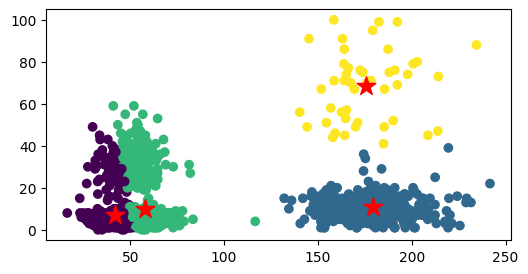

In [14]:
cDx, Dyp,cDxIni = MyKMeansPlusPlus(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# 🎯 **EJ 2: USA EL METODO DEL CODO CON KMEANS++ PARA DETERMINAR EL MEJOR K**
<hr>
<h2>Elegir el mejor valor de K</h2>

Para elegir el mejor valor de K se suele usar la técnica del codo. Ésta consiste en probar diferentes valores de K y evaluar el agrupamientos según alguna medida de evaluación intrínseca (ya que se supone que no se conoce la verdad básica). En este ejemplo, se usan dos medidas diferentes: la medida de Silueta y la R cuadrado.


In [15]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [16]:
def medida_R_cuadrado(X, Xyp, cXs):
    # Calcular SST (Suma Total de Cuadrados)
    centro_global = np.mean(X, axis=0)
    SST = np.sum(np.sum((X - centro_global)**2, axis=1))
    # Calcular SSE (Suma de Cuadrados del Error)
    SSE = 0
    for i in range(len(X)):
        # Encontrar el centroide correspondiente para cada punto
        cluster_label = int(Xyp[i])
        centroide = cXs[cluster_label]
        SSE += np.sum((X[i] - centroide)**2)

    # Calcular R²
    if SST == 0:
        return 1.0
    R_cuadrado = 1 - (SSE / SST)
    return R_cuadrado

Text(0, 0.5, 'Medida de R cuadrado')

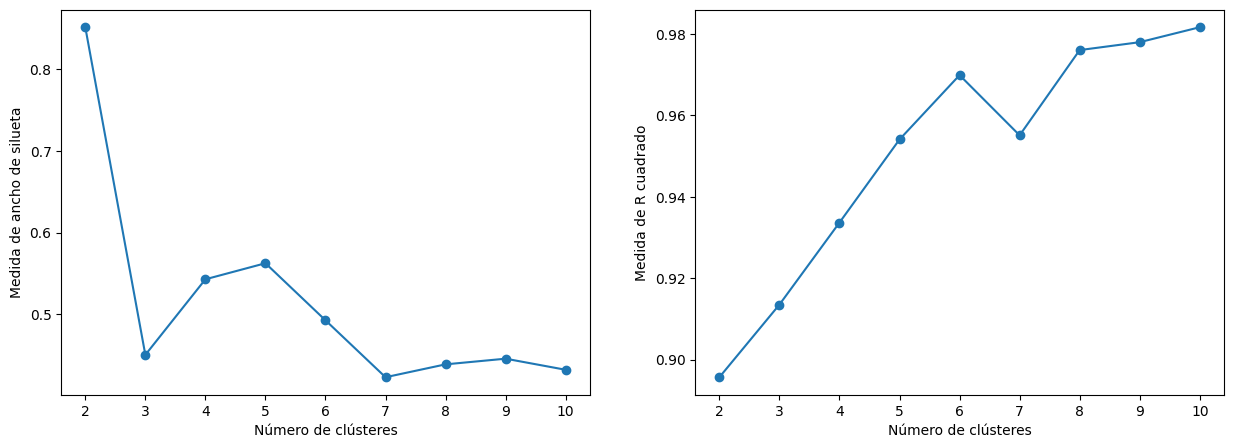

In [20]:
#METODO DEL CODO
# voy a probar para valores de k desde 2 al 11
rsilueta = np.zeros(9)
rrsquare = np.zeros(9)
for k in np.arange(2,11):
    cDx, Dyp,cDxIni = MyKMeansPlusPlus(Dx, k)
    rsilueta[k-2] = silhouette_score(Dx, Dyp)
    rrsquare[k-2] = medida_R_cuadrado(Dx, Dyp, cDx)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot( np.arange(2,11),rsilueta, linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de ancho de silueta")

ax[1].plot( np.arange(2,11),rrsquare, linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Medida de R cuadrado")

Redacte una conclusión que analice los gráficos del método del codo y del coeficiente de silueta (y/o R²) para la selección del número de clusters (k). Indique cuál es el valor óptimo de k y fundamente su elección con base en la interpretación de dichos gráficos.

Basándonos en los gráficos del coeficiente de silueta y la medida de R cuadrado, podemos decir que:

Coeficiente de Silueta: El gráfico muestra un pico inicial en K=2 con un valor alto, lo que sugiere una buena separación de los clústeres para dos grupos. Sin embargo, también presenta valores razonables en otros K, y la interpretación debe hacerse en conjunto con otras métricas.

Medida de R Cuadrado (Método del Codo): El gráfico de R cuadrado, que es análogo al método del codo al buscar el punto donde la mejora en la explicación de la varianza se ralentiza, muestra un aumento significativo hasta K=4 o K=5, y a partir de ahí, la curva tiende a aplanarse. Esto sugiere que a partir de K=4 o K=5, los beneficios de añadir más clústeres en términos de explicar la varianza son decrecientes.

Conclusión y Elección de K óptimo: Considerando ambas métricas, y buscando un equilibrio entre la cohesión interna (inercia implícita en R-cuadrado) y la separación entre clústeres (silueta), el valor óptimo de K es 4. Aunque la silueta tiene un pico en K=2, el R-cuadrado sugiere que K=4 es un punto donde se logra una explicación considerable de la varianza con un número razonable de clústeres antes de que los rendimientos disminuyan.

Text(0, 0.5, 'Índice de Calinski-Harabasz')

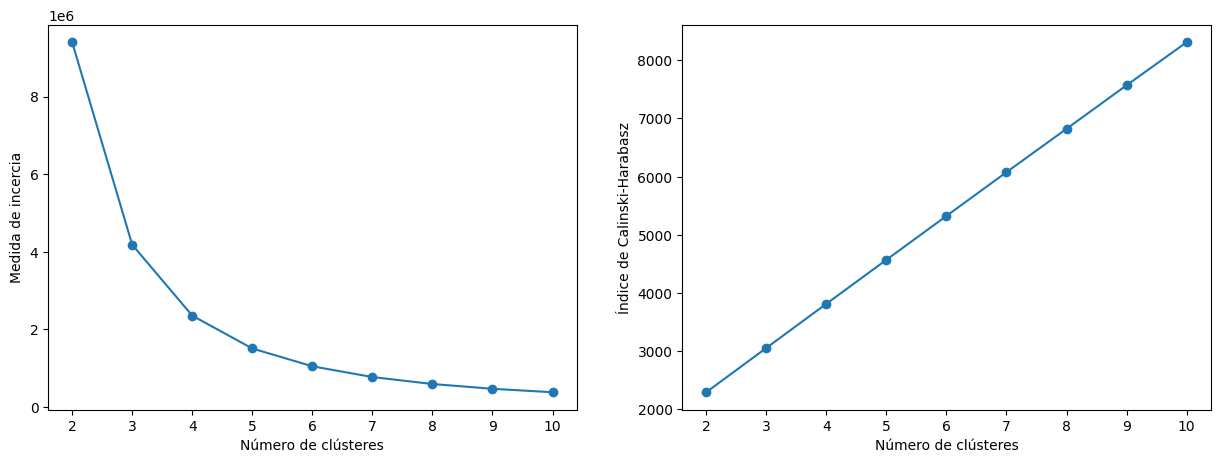

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

rincercia = np.zeros(9)
rcalinski = np.zeros(9)
for k in np.arange(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(Dx)
    rincercia[k-2] =  kmeans.inertia_
    rcalinski[k-2] = calinski_harabasz_score(Dx, kmeans.labels_)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot( np.arange(2,11),rincercia, linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de incercia")

# 2.3 Complete el codigo anterior para graficar el indice de calinski
ax[1].plot( np.arange(2,11),rcalinski, linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Índice de Calinski-Harabasz")

Redacte una conclusión comparativa basada en el gráfico de inercia (método del codo) y el índice de Calinski-Harabasz. Determine el número óptimo de clusters (k) e interprete cómo cada métrica justifica dicha selección.

Basándonos en los gráficos de inercia (método del codo) y el índice de Calinski-Harabasz, podemos determinar el número óptimo de clústeres (K):

Gráfico de Inercia (Método del Codo): Observamos una disminución pronunciada de la inercia a medida que K aumenta. El 'codo' en este gráfico, donde la tasa de disminución de la inercia comienza a ralentizarse notablemente, se sitúa alrededor de K=4 o K=5. Esto sugiere que añadir más clústeres más allá de este punto no proporciona una mejora sustancial en la compactibilidad de los clústeres.

Índice de Calinski-Harabasz: Este índice mide la relación entre la dispersión inter-clúster y la dispersión intra-clúster. Generalmente, un valor más alto indica clústeres mejor definidos. En el gráfico, el índice de Calinski-Harabasz muestra una tendencia creciente a lo largo de todo el rango de K (hasta K=10). No se observa un pico claro que indique un K óptimo definitivo solo con esta métrica en este rango.

Conclusión Comparativa y Selección de K óptimo: Considerando ambas métricas, y buscando un equilibrio entre la compactibilidad de los clústeres (inercia) y su buena definición (Calinski-Harabasz), K=4 se presenta como una opción razonable. Aunque el índice de Calinski-Harabasz sigue aumentando con K, el método del codo sugiere que K=4 es un punto donde se logra una buena reducción de la inercia, lo que implica una partición significativa de los datos. Elegir K=4 permite capturar la estructura principal de los datos sin introducir demasiada complejidad, basándonos en la evidencia del 'codo' en la inercia.



# 🎯 **EJ 3: USA EL SIGUIENTE DATASET CON KMEANS++**
Cargue el dataset dataset_cuatro_separables_peque y realice el siguiente análisis de agrupamiento (clustering):

Determinación del k óptimo: Utilice el algoritmo k-means para calcular y graficar el método del codo con un rango de k razonable (por ejemplo, de 2 a 15 clusters).

Selección: Con base en los gráficos, justifique y seleccione el número óptimo de clusters (k_optimo).

Modelo final: Ajuste un modelo final de k-means utilizando el k_optimo.

Visualización: Visualice los resultados del agrupamiento y que los puntos estén coloreados según el cluster asignado. Incluya los centroides en la visualización.

### Selección del K óptimo y ajuste del modelo final para `dataset_cuatro_separables_peque.xlsx`

Con base en el análisis de los gráficos del método del codo (Inercia), el Coeficiente de Silueta y la Medida de R Cuadrado, seleccionamos **K=4** como el número óptimo de clústeres para este dataset.

Ajustaremos un modelo final de K-Means++ con `k_optimo = 4` y visualizaremos los resultados.

✅ Dataset cargado desde URL GitHub


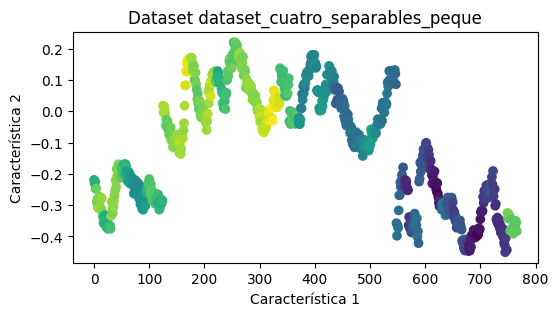

In [26]:
# Cargar dataset 'dataset_cuatro_separables_peque.xlsx'
D = cargar_dataset("dataset_cuatro_separables_peque.xlsx")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)
plt.title("Dataset dataset_cuatro_separables_peque")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()

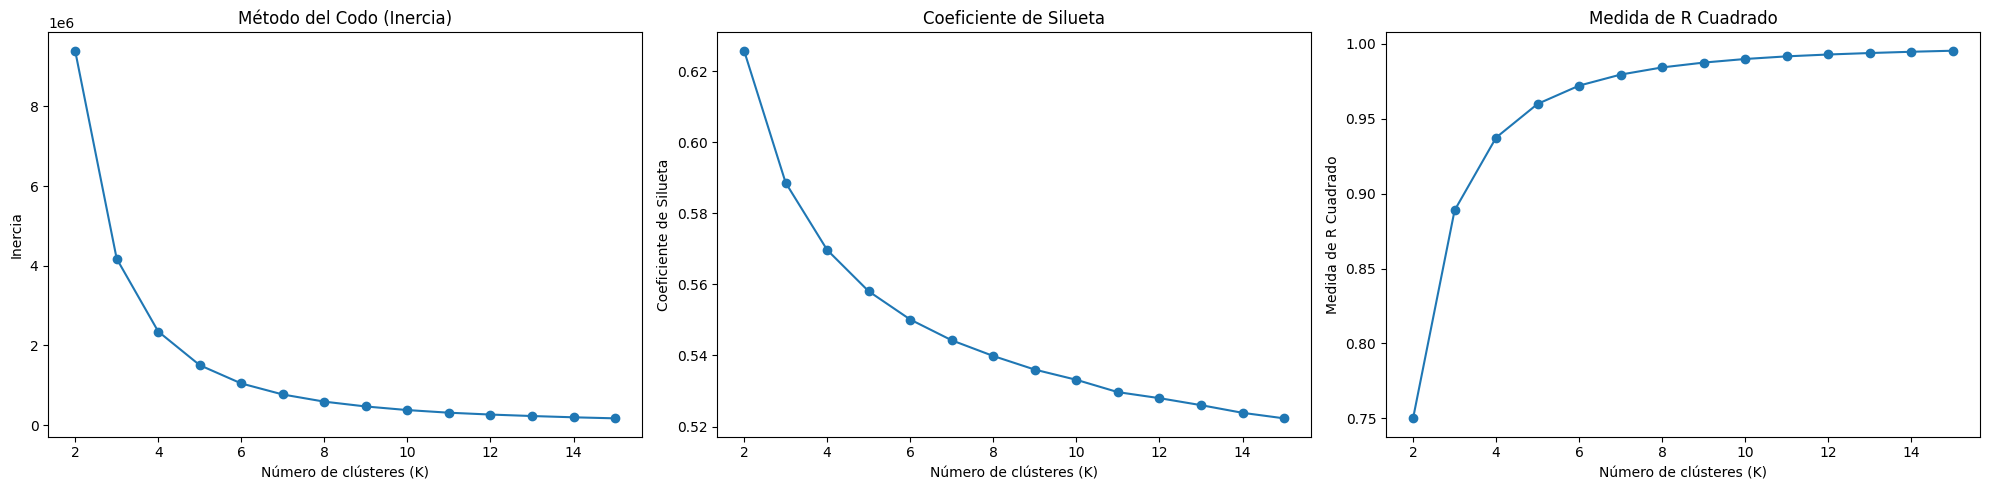

In [27]:
from sklearn.metrics import silhouette_score

r_inertia = []
r_silhouette = []
r_rsquare = []

k_range = np.arange(2, 16)

for k in k_range:
    cDx, Dyp, _ = MyKMeansPlusPlus(Dx, k)

    current_inertia = 0
    for i in range(Dx.shape[0]):
        current_inertia += np.linalg.norm(Dx[i] - cDx[int(Dyp[i])])**2
    r_inertia.append(current_inertia)

    r_silhouette.append(silhouette_score(Dx, Dyp))
    r_rsquare.append(medida_R_cuadrado(Dx, Dyp, cDx))

# Graficar los resultados
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(k_range, r_inertia, linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres (K)")
ax[0].set_ylabel("Inercia")
ax[0].set_title("Método del Codo (Inercia)")

ax[1].plot(k_range, r_silhouette, linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres (K)")
ax[1].set_ylabel("Coeficiente de Silueta")
ax[1].set_title("Coeficiente de Silueta")

ax[2].plot(k_range, r_rsquare, linestyle='-', marker='o')
ax[2].set_xlabel("Número de clústeres (K)")
ax[2].set_ylabel("Medida de R Cuadrado")
ax[2].set_title("Medida de R Cuadrado")

plt.tight_layout()
plt.show()

Basándonos en los gráficos, K=4 es el número óptimo de clústeres. El método del codo (inercia) muestra un punto de inflexión claro en K=4, indicando que más clústeres no aportan mejoras significativas. El coeficiente de silueta es alto en K=4, lo que sugiere una buena separación entre los clústeres. Finalmente, la medida de R-cuadrado también valida K=4 al explicar una buena parte de la varianza.

In [28]:
k_optimo = 4
final_cDx, final_Dyp, _ = MyKMeansPlusPlus(Dx, k_optimo)

print(f"Centroides finales para k={k_optimo}:\n{final_cDx}")
print(f"Asignaciones de clúster para los primeros 10 puntos:\n{final_Dyp[:10]}")

Centroides finales para k=4:
[[ 6.71500000e+02 -3.15417847e-01]
 [ 9.60000000e+01 -1.69528140e-01]
 [ 2.89000000e+02  5.60044376e-02]
 [ 4.81000000e+02 -2.92349268e-02]]
Asignaciones de clúster para los primeros 10 puntos:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


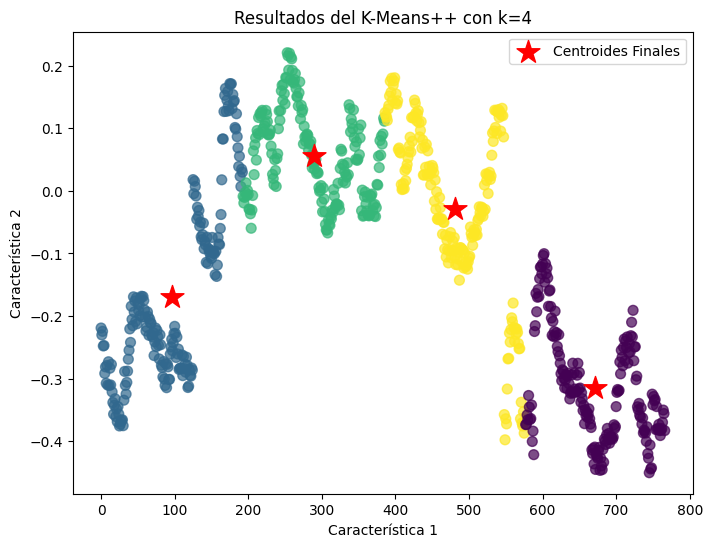

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(Dx[:, 0], Dx[:, 1], c=final_Dyp, cmap='viridis', s=50, alpha=0.7)
ax.scatter(final_cDx[:, 0], final_cDx[:, 1], marker='*', s=300, c='red', label='Centroides Finales')
ax.set_title(f'Resultados del K-Means++ con k={k_optimo}')
ax.set_xlabel('Característica 1')
ax.set_ylabel('Característica 2')
ax.legend()
plt.show()

# 🚀 ¡TALLER FINALIZADO!"